In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.constraints import max_norm, unit_norm, min_max_norm
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Train_SIRI-WHU.h5', 'r')
    train_set_x_orig = np.array(train_dataset["X_train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["Y_train_dataset"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Test_SIRI-WHU.h5', 'r')
    test_set_x_orig = np.array(test_dataset["X_test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["Y_test_dataset"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (Dataset)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


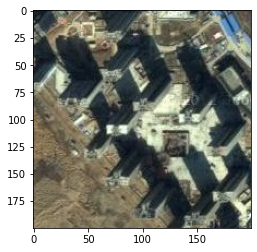

In [ ]:
#for i in range(X_train_orig.shape[0]):
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='HSV')
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='YCbCr')

#for j in range(X_test_orig.shape[0]):
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='HSV')
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='YCbCr')

index = 25
plt.imshow(Image.fromarray(X_train_orig[index].astype(np.uint8)))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 12)
Y_test = convert_to_one_hot(Y_test_orig, 12)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1920
number of test examples = 480
X_train shape: (1920, 200, 200, 3)
Y_train shape: (1920, 12)
X_test shape: (480, 200, 200, 3)
Y_test shape: (480, 12)


In [ ]:
VGG_Out = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Convout/TLConvFnl/VGG_Out.h5', 'r')
Txtrain = np.array(VGG_Out["train_Outvgg"][:])
Txtest = np.array(VGG_Out["test_Outvgg"][:])
VGG_Out.close()

print("Txtrain shape:", Txtrain.shape)
print("Txtest shape:", Txtest.shape)

Txtrain shape: (1920, 7, 7, 512)
Txtest shape: (480, 7, 7, 512)


In [ ]:
model = models.Sequential()
model.add(layers.Input(shape = (7,7,512)))
model.add(layers.Flatten())
model.add(layers.ReLU())
model.add(layers.Dropout(0.77))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2=0.5)))
#model.add(layers.Dropout(0.77))
#model.add(layers.Dense(150, activation='relu', kernel_regularizer=regularizers.l2(l2=0.5)))
#model.add(layers.Dropout(0.77))
model.add(layers.Dense(21, activation='softmax', kernel_regularizer=regularizers.l2(l2=0.5)))
print(model.summary())
optimizers.Adam(learning_rate=0.01,name="Adam")
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Vhistory = model.fit(Txtrain, Y_train, epochs=200, verbose=1, batch_size=256, validation_split = 0.25)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
re_lu (ReLU)                 (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5397      
Total params: 6,428,181
Trainable params: 6,428,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
5/5 [==============================] - 2s 375ms/step - loss: 277.2061 - accuracy: 0.2220 - val_

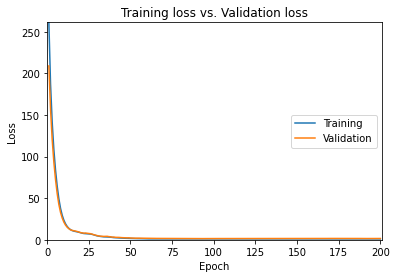

In [ ]:

epochs = len(Vhistory.history['loss'])
max_loss = max(max(Vhistory.history['loss']), max(Vhistory.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['loss'])
plt.plot(x, Vhistory.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

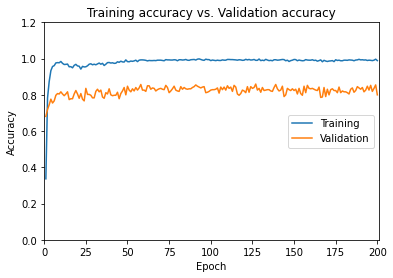

In [ ]:
epochs = len(Vhistory.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['accuracy'])
plt.plot(x, Vhistory.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [ ]:
#np.random.seed(8)

#epochs = np.argmin(Vhistory.history['val_loss']) + 1
epochs = np.argmax(Vhistory.history['val_accuracy']) +1

history = model.fit(Txtrain, Y_train, epochs=epochs, verbose=1, batch_size=256, validation_split=0)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

test_loss, test_acc = model.evaluate(Txtest,  Y_test, verbose=1)
print("Loss: ", test_loss, " Test Accuracy: ", test_acc)

Epoch 1/127
7/7 [==============================] - 2s 213ms/step - loss: 1.2747 - accuracy: 0.9815
Epoch 2/127
7/7 [==============================] - 1s 211ms/step - loss: 1.2828 - accuracy: 0.9845
Epoch 3/127
7/7 [==============================] - 1s 206ms/step - loss: 1.2490 - accuracy: 0.9863
Epoch 4/127
7/7 [==============================] - 1s 212ms/step - loss: 1.2472 - accuracy: 0.9863
Epoch 5/127
7/7 [==============================] - 1s 209ms/step - loss: 1.2309 - accuracy: 0.9869
Epoch 6/127
7/7 [==============================] - 1s 210ms/step - loss: 1.2060 - accuracy: 0.9887
Epoch 7/127
7/7 [==============================] - 1s 210ms/step - loss: 1.2289 - accuracy: 0.9804
Epoch 8/127
7/7 [==============================] - 1s 211ms/step - loss: 1.2408 - accuracy: 0.9869
Epoch 9/127
7/7 [==============================] - 1s 207ms/step - loss: 1.2251 - accuracy: 0.9792
Epoch 10/127
7/7 [==============================] - 1s 212ms/step - loss: 1.2849 - accuracy: 0.9905
Epoch 11/

In [ ]:
import pandas as pd

array1 = np.zeros((200,2))
array1[:,0] = Vhistory.history['loss']
array1[:,1] = Vhistory.history['val_loss']

array2 = np.zeros((200,2))
array2[:,0] = Vhistory.history['accuracy']
array2[:,1] = Vhistory.history['val_accuracy']

df1 = pd.DataFrame(array1)
df1.to_excel("/content/drive/My Drive/Datasets/UCMerced_LandUse/ImpVGGML1.xlsx", sheet_name='Merced Loss')

df2 = pd.DataFrame(array2)
df2.to_excel("/content/drive/My Drive/Datasets/UCMerced_LandUse/ImpVGGMA1.xlsx", sheet_name='Merced accuracy')

In [ ]:
model.save('/content/drive/My Drive/Datasets/UCMerced_LandUse/Convout/TLConvFnl/ImpVGG16_model1')
model.save_weights('/content/drive/My Drive/Datasets/UCMerced_LandUse/Convout/TLConvFnl/ImpVGG16_Wieghts1.h5')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Datasets/SIRI-WHU/Convout/TLConvFnl/ImpVGG16_model1/assets


In [ ]:
mmmodel = models.load_model('/content/drive/My Drive/Datasets/SIRI-WHU/Convout/TLConvFnl/ImpVGG16_model1')
train_loss, train_acc = mmmodel.evaluate(Txtrain ,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

test_loss, test_acc = mmmodel.evaluate(Txtest,  Y_test, verbose=1)
print("Loss: ", test_loss, " Test Accuracy: ", test_acc)

60/60 [==============================] - 2s 27ms/step - loss: 1.0702 - accuracy: 0.9990
Loss:  1.070189118385315  Train Accuracy:  0.9989583492279053
15/15 [==============================] - 0s 26ms/step - loss: 1.3105 - accuracy: 0.9396
Loss:  1.3104608058929443  Test Accuracy:  0.9395833611488342


In [ ]:
Y_Pred = mmmodel.predict_classes(Txtest)

#print(Y_Pred)
#print(Y_Pred.shape)

#print(Y_test_orig)
#print(Y_test_orig.shape)
#print(Y_test_orig.shape[1])

Y_test_orig_L = []
Y_Pred_L = []

LLLU=["agricultural", "airplane", "baseballdiamond", "beach", "buildings", "chaparral", "denseresidential",
                    "forest", "freeway", "golfcourse", "harbor", "intersection", "mediumresidential", "mobilehomepark",
                    "overpass", "parkinglot", "river", "runway", "sparseresidential", "storagetanks", "tenniscourt"]

LLLS=["agriculture", "commercial", "harbor", "idle_land", "industrial", "meadow", "overpass",
                    "park", "pond", "residential", "river", "water"]


for i in range (Y_test_orig.shape[1]):
  Y_test_orig_L.append(LLLS[Y_test_orig[0,i]])
  Y_Pred_L.append(LLLS[Y_Pred[i]])

#print(LLLU)
#print(Y_test_orig_L)
#print(Y_Pred_L)

CM = confusion_matrix(Y_test_orig_L, Y_Pred_L, labels=LLLS)

print(CM)
print(CM.shape)

print(classification_report(Y_test_orig_L, Y_Pred_L, labels=LLLS))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[40  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  1  0  0  1  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  1  0  0  0  0  3  0]
 [ 0  0  0  0 40  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 38  0  1  1  0  0  0]
 [ 0  0  0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0  2  0 38  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 38  0  1  0]
 [ 0  3  0  0  0  0  0  0  0 37  0  0]
 [ 0  3  3  2  1  1  1  0  2  0 27  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 39]]
(12, 12)
              precision    recall  f1-score   support

 agriculture       1.00      1.00      1.00        40
  commercial       0.86      0.95      0.90        40
      harbor       0.91      1.00      0.95        40
   idle_land       0.95      0.90      0.92        40
  industrial       0.95      1.00      0.98        40
      meadow       0.88      0.95      0.92        40
    overpass       0.98      1.00      0.99        40
        park       0.95      0.95      0.95        40
        pond       0.93      0.95  